In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
df = pd.read_csv('Beehive Metrics Dataset/weight_2017.csv')
df.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [3]:
#How many rows?
len(df.index)

524110

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524110 entries, 0 to 524109
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  524110 non-null  object 
 1   weight     524110 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.0+ MB


In [5]:
#Change the timestamp field to a datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#Print the info again to ensure the data type was changed successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524110 entries, 0 to 524109
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  524110 non-null  datetime64[ns]
 1   weight     524110 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 MB


In [7]:
#Show some data again to ensure that the timestamps didn't get messed up
df.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [8]:
#Show mean, standard dev, min, max, and IQRs
df.describe()

,weight
count,524110.000000
mean,55.949812
std,6.142653
min,-0.115216
25%,50.712700
50%,55.001700
75%,59.867400
max,68.702400


In [9]:
#Count blanks or whitespaces
df = df.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
df.isnull().sum()

timestamp    0
weight       0
dtype: int64

In [10]:
#None in this data set!
#df[df.isna().any(axis=1)]

In [11]:
#How many unique values?
for column in df:
    print(column, len(df[column].unique()))
#Why are there only half as many unique values for timestamps as there are rows

timestamp 524050
weight 42469


array([[<AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

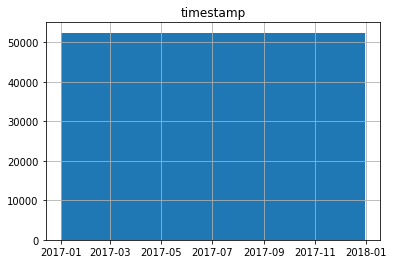

In [12]:
#Histogram of timestamps, should be even across the board
#Measured every minute
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(column='timestamp')

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

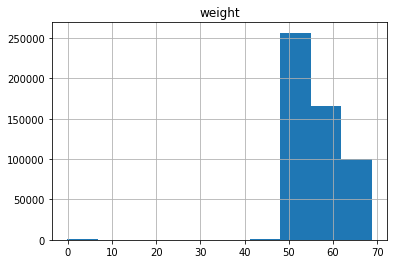

In [13]:
#And weight...
df.hist(column='weight')

In [14]:
#Seems like we have a bunch of outliers this time
#Q1 is 50, so let's just drop values that are really low
outliers = df.loc[df['weight']<20]
outliers

,timestamp,weight
115707,2017-03-22 13:42:00,-0.115216
115708,2017-03-22 13:43:00,-0.115216
115709,2017-03-22 13:44:00,-0.115216
188789,2017-05-12 08:44:00,-0.083207
188790,2017-05-12 08:45:00,-0.083207
...,...,...
407745,2017-10-11 10:50:00,-0.115216
508766,2017-12-20 13:31:00,-0.115216
508767,2017-12-20 13:32:00,-0.115216
508768,2017-12-20 13:33:00,-0.115216


array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

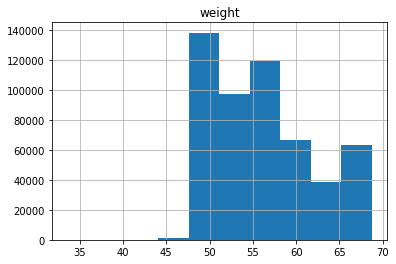

In [15]:
#We have a lot of them, and some seem to be negative actually. Let's drop them
outlierIDs = outliers.index.tolist()
for index in outlierIDs:
    df = df.drop(index)
df.hist(column='weight')

In [16]:
#Any duplicates?
df[df.duplicated()].sum()

weight    393.366
dtype: float64

In [17]:
#Not sure if we should drop duplicates still
df[df.duplicated()]

,timestamp,weight
433202,2017-10-29 02:07:00,56.218
433214,2017-10-29 02:19:00,56.218
433236,2017-10-29 02:41:00,56.218
433237,2017-10-29 02:42:00,56.154
433246,2017-10-29 02:51:00,56.154
433249,2017-10-29 02:54:00,56.218
433253,2017-10-29 02:58:00,56.186


In [15]:
#Show mean, standard dev, min, max, and IQRs after dropping rows
df.describe()

,weight
count,523454.000000
mean,56.014759
std,5.852083
min,40.502300
25%,50.712700
50%,55.001700
75%,59.868500
max,68.702400


In [18]:
#Get median, mode, variance
print("median", df['weight'].median())
print("mode", mode(df['weight']).mode[0])
print("variance", df['weight'].var())

median 55.0017
mode 48.85630000000001
variance 34.307504642021534


,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973
...,...,...
524105,2017-12-31 05:10:00,53.8495
524106,2017-12-31 05:11:00,53.7214
524107,2017-12-31 05:12:00,53.6574
524108,2017-12-31 05:13:00,53.7214
